In [ ]:
!pip install transformers==5.0.0rc0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.0/521.0 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.3
    Uninstalling transformers-4.57.3:
      Successfully uninstalled transformers-4.57.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.1.2 requires transformers<5.0.0,>=4.41.0, but you have transformers 5.0.0rc0 which is incompatible.


In [ ]:
!pip install -q --upgrade bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 14.0 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig # لاحظ استخدام AutoModel

model_id = "zai-org/GLM-4.6V-Flash"

# إعدادات الضغط (4-بت)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# التغيير هنا: استخدام AutoModel بدلاً من AutoModelForCausalLM
model = AutoModel.from_pretrained(
    model_id,
    quantization_config=bnb_config, # تمرير إعدادات الضغط
    device_map="auto",
    trust_remote_code=True, # ضروري جداً لتعريف mrope_section
    low_cpu_mem_usage=True
)

print("تم تحميل النموذج البصري بنجاح!")

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section', 'partial_rotary_factor'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/703 [00:00<?, ?it/s]

Glm4vModel LOAD REPORT from: zai-org/GLM-4.6V-Flash
Key            | Status     |  | 
---------------+------------+--+-
lm_head.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


تم تحميل النموذج البصري بنجاح!


In [ ]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration
from PIL import Image

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعداد ضغط 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# --- اقرأ الصورة من ملف محلي ---
image_path = "/content/Grayscale_8bits_palette_sample_image.png"   # عدِّل هذا إلى مسار الصورة عندك
image = Image.open(image_path).convert("RGB")

# إعداد رسالة: صورة + نص
messages = [
    {
        "role": "user",
        "content": [
            # لن تحتاج url لأن الصورة محليّة
            {"type": "image"},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# تجهيز المدخلات: الصور + النص
chat_template = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text=chat_template,
    images=[image],
    return_tensors="pt"
)

# نقل التينسورات إلى نفس جهاز النموذج (GPU أو CPU)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد النص (الوصف)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=51)

output = processor.decode(
    generated_ids[0][ inputs["input_ids"].shape[1]: ],
    skip_special_tokens=True
)

print(output)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/704 [00:00<?, ?it/s]

<think>Got it, let's describe this black-and-white image of a parrot. First, the main subject is a parrot, likely a macaw or similar species, with a prominent crest on its head. The parrot is perched on a


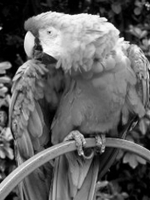

In [ ]:
from IPython.display import Image as IPImage

# تأكد أن مسار الصورة صحيح
image_path = "/content/Grayscale_8bits_palette_sample_image.png"

# عرض الصورة
IPImage(filename=image_path)

In [ ]:
!pip install -q --upgrade transformers bitsandbytes accelerate
# إذا كنت تستخدم Kaggle، قد تحتاج لتحديث المكتبات لأن النسخ القديمة تسبب مشاكل

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# مسار النموذج
model_id = "zai-org/GLM-4.6V-Flash"

# إعدادات الضغط لتقليل الحجم إلى 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16 # استخدام fp16 للحسابات لزيادة السرعة
)

# تحميل الـ Tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# تحميل النموذج مع توزيع تلقائي (مهم لـ Kaggle) وضغط (مهم لـ Colab)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",  # هذا السطر مهم جداً لكاجل لتوزيع الحمل، ولكولاب لضبط الذاكرة
    trust_remote_code=True,
    low_cpu_mem_usage=True # يمنع امتلاء الرام العادية أثناء التحميل
)

print("تم تحميل النموذج بنجاح!")

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section', 'partial_rotary_factor'}


ValueError: Unrecognized configuration class <class 'transformers.models.glm4v.configuration_glm4v.Glm4vConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of AfmoeConfig, ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitNetConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, BltConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, CwmConfig, Data2VecTextConfig, DbrxConfig, DeepseekV2Config, DeepseekV3Config, DiffLlamaConfig, DogeConfig, Dots1Config, ElectraConfig, Emu3Config, ErnieConfig, Ernie4_5Config, Ernie4_5_MoeConfig, Exaone4Config, FalconConfig, FalconH1Config, FalconMambaConfig, FlexOlmoConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, Gemma3nConfig, Gemma3nTextConfig, GitConfig, GlmConfig, Glm4Config, Glm4MoeConfig, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GptOssConfig, GPTJConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeHybridConfig, GraniteMoeSharedConfig, HeliumConfig, HunYuanDenseV1Config, HunYuanMoEV1Config, JambaConfig, JetMoeConfig, Lfm2Config, Lfm2MoeConfig, LlamaConfig, Llama4Config, Llama4TextConfig, LongcatFlashConfig, MambaConfig, Mamba2Config, MarianConfig, MBartConfig, MegatronBertConfig, MiniMaxConfig, MinistralConfig, Ministral3Config, MistralConfig, MixtralConfig, MllamaConfig, ModernBertDecoderConfig, MoshiConfig, MptConfig, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NanoChatConfig, NemotronConfig, OlmoConfig, Olmo2Config, Olmo3Config, OlmoeConfig, OpenAIGPTConfig, OPTConfig, PegasusConfig, PersimmonConfig, PhiConfig, Phi3Config, Phi4MultimodalConfig, PhimoeConfig, PLBartConfig, ProphetNetConfig, Qwen2Config, Qwen2MoeConfig, Qwen3Config, Qwen3MoeConfig, Qwen3NextConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, SeedOssConfig, SmolLM3Config, StableLmConfig, Starcoder2Config, TrOCRConfig, VaultGemmaConfig, WhisperConfig, XGLMConfig, XLMConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, xLSTMConfig, XmodConfig, ZambaConfig, Zamba2Config.

In [ ]:
from transformers import AutoProcessor, Glm4vForConditionalGeneration
import torch

MODEL_PATH = "zai-org/GLM-4.6V-Flash"
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
            },
            {
                "type": "text",
                "text": "describe this image"
            }
        ],
    }
]
processor = AutoProcessor.from_pretrained(MODEL_PATH)
model = Glm4vForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    torch_dtype="auto",
    device_map="auto",
)
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)
inputs.pop("token_type_ids", None)
generated_ids = model.generate(**inputs, max_new_tokens=8192)
output_text = processor.decode(generated_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=False)
print(output_text)


KeyboardInterrupt: 

شغال

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, BitsAndBytesConfig # لاحظ استخدام AutoModel

model_id = "zai-org/GLM-4.6V-Flash"

# إعدادات الضغط (4-بت)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# التغيير هنا: استخدام AutoModel بدلاً من AutoModelForCausalLM
model = AutoModel.from_pretrained(
    model_id,
    quantization_config=bnb_config, # تمرير إعدادات الضغط
    device_map="auto",
    trust_remote_code=True, # ضروري جداً لتعريف mrope_section
    low_cpu_mem_usage=True
)

print("تم تحميل النموذج البصري بنجاح!")

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section', 'partial_rotary_factor'}


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/703 [00:00<?, ?it/s]

Glm4vModel LOAD REPORT from: zai-org/GLM-4.6V-Flash
Key            | Status     |  | 
---------------+------------+--+-
lm_head.weight | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


تم تحميل النموذج البصري بنجاح!


In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from transformers import AutoProcessor
from PIL import Image
import requests

# 1. إعدادات الضغط (NF4) - السر في تشغيل النموذج على T4
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

model_id = "zai-org/GLM-4.6V-Flash"

print("جاري تحميل النموذج (قد يستغرق دقيقتين)...")

# 2. تحميل النموذج الصحيح (ForCausalLM) مع الضغط
# استخدام trust_remote_code=True ضروري جداً هنا
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config, # تفعيل NF4
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

# 3. تحميل المعالج (Processor)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("تم تحميل النموذج بضغط NF4 وهو جاهز للتحدث!")

# ==========================================
# تجربة النموذج الآن
# ==========================================

# صورة للتجربة
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# إعداد الرسالة
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# تجهيز المدخلات
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

# التوليد
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

# طباعة النتيجة
generated_text = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("-" * 30)
print(generated_text)

جاري تحميل النموذج (قد يستغرق دقيقتين)...


Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


ValueError: Unrecognized configuration class <class 'transformers.models.glm4v.configuration_glm4v.Glm4vConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of AfmoeConfig, ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitNetConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, BltConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, CwmConfig, Data2VecTextConfig, DbrxConfig, DeepseekV2Config, DeepseekV3Config, DiffLlamaConfig, DogeConfig, Dots1Config, ElectraConfig, Emu3Config, ErnieConfig, Ernie4_5Config, Ernie4_5_MoeConfig, Exaone4Config, FalconConfig, FalconH1Config, FalconMambaConfig, FlexOlmoConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, Gemma3nConfig, Gemma3nTextConfig, GitConfig, GlmConfig, Glm4Config, Glm4MoeConfig, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GptOssConfig, GPTJConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeHybridConfig, GraniteMoeSharedConfig, HeliumConfig, HunYuanDenseV1Config, HunYuanMoEV1Config, JambaConfig, JetMoeConfig, Lfm2Config, Lfm2MoeConfig, LlamaConfig, Llama4Config, Llama4TextConfig, LongcatFlashConfig, MambaConfig, Mamba2Config, MarianConfig, MBartConfig, MegatronBertConfig, MiniMaxConfig, MinistralConfig, Ministral3Config, MistralConfig, MixtralConfig, MllamaConfig, ModernBertDecoderConfig, MoshiConfig, MptConfig, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NanoChatConfig, NemotronConfig, OlmoConfig, Olmo2Config, Olmo3Config, OlmoeConfig, OpenAIGPTConfig, OPTConfig, PegasusConfig, PersimmonConfig, PhiConfig, Phi3Config, Phi4MultimodalConfig, PhimoeConfig, PLBartConfig, ProphetNetConfig, Qwen2Config, Qwen2MoeConfig, Qwen3Config, Qwen3MoeConfig, Qwen3NextConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, SeedOssConfig, SmolLM3Config, StableLmConfig, Starcoder2Config, TrOCRConfig, VaultGemmaConfig, WhisperConfig, XGLMConfig, XLMConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, xLSTMConfig, XmodConfig, ZambaConfig, Zamba2Config.

In [ ]:
import torch
from transformers import AutoConfig, BitsAndBytesConfig, AutoProcessor
from transformers.dynamic_module_utils import get_class_from_dynamic_module
from PIL import Image
import requests

model_id = "zai-org/GLM-4.6V-Flash"

print("1. جاري قراءة إعدادات النموذج...")
# تحميل الإعدادات لمعرفة اسم الكلاس الصحيح
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# استخراج اسم الكلاس المسؤول عن المحادثة من داخل ملف الإعدادات
# هذا السطر هو الحل السحري لتفادي خطأ ValueError
class_path = config.auto_map["AutoModelForCausalLM"]
print(f"   تم تحديد الكلاس المطلوب: {class_path}")

# جلب الكلاس برمجياً من الملفات البعيدة
ModelClass = get_class_from_dynamic_module(class_path, model_id)

print("2. جاري تحميل النموذج مع ضغط NF4 (هذه الخطوة الأثقل)...")
# إعدادات الضغط
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# تحميل النموذج باستخدام الكلاس المستخرج مباشرة
model = ModelClass.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

print("3. جاري تحميل المعالج (Processor)...")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("\n✅ تم التحميل بنجاح! النموذج جاهز الآن.")

# ==========================================
# اختبار التشغيل الفوري
# ==========================================

# تحميل صورة
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image."}
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

print("4. جاري التوليد...")
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

result = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("-" * 30)
print("الرد:", result)

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


1. جاري قراءة إعدادات النموذج...


AttributeError: 'Glm4vConfig' object has no attribute 'auto_map'

In [ ]:
import torch
import json
from transformers import AutoConfig, BitsAndBytesConfig, AutoProcessor
from transformers.dynamic_module_utils import get_class_from_dynamic_module
from PIL import Image
import requests

model_id = "zai-org/GLM-4.6V-Flash"

print("1. جاري استخراج اسم الكلاس الصحيح يدوياً...")
# تحميل الإعدادات
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)

# --- الإصلاح هنا ---
# بدلاً من config.auto_map التي سببت الخطأ، نحول الإعدادات لقاموس ثم نقرأ منه
# هذا يضمن الحصول على المسار حتى لو كان الكائن يخفيه
config_dict = config.to_dict()
class_path = config_dict["auto_map"]["AutoModelForCausalLM"]
print(f"   --> تم العثور على المسار: {class_path}")

# تحميل الكلاس برمجياً (Dynamically loading the class)
ModelClass = get_class_from_dynamic_module(class_path, model_id)

print("2. جاري تحميل النموذج مع ضغط NF4 (للحماية من كراش الرام)...")
# إعدادات bitsandbytes لحماية الذاكرة
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# تحميل النموذج باستخدام الكلاس المستخرج
model = ModelClass.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

print("3. جاري تحميل المعالج (Processor)...")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("\n✅ تمت المهمة! النموذج جاهز تماماً.")

# ==========================================
# اختبار التشغيل
# ==========================================
print("4. جاري تجربة تحليل صورة...")
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

result = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("-" * 30)
print(result)

1. جاري استخراج اسم الكلاس الصحيح يدوياً...


Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


KeyError: 'auto_map'

In [2]:
import torch
from transformers import AutoConfig, BitsAndBytesConfig, AutoProcessor
from transformers.dynamic_module_utils import get_class_from_dynamic_module
from PIL import Image
import requests

model_id = "zai-org/GLM-4.6V-Flash"

print("1. جاري استدعاء كلاس النموذج مباشرة (تجاوز الأخطاء)...")

# --- الحل السحري ---
# بدلاً من البحث في الإعدادات، نطلب الملف والكلاس بالاسم مباشرة
# هذا المسار مستنتج من نوع الكونفج الذي ظهر في أخطائك السابقة
try:
    ModelClass = get_class_from_dynamic_module(
        "modeling_glm4v.Glm4vForConditionalGeneration",
        model_id
    )
except OSError:
    # محاولة احتياطية في حال كان اسم الملف مختلفاً
    print("   ... محاولة مسار بديل ...")
    ModelClass = get_class_from_dynamic_module(
        "modeling_chatglm.ChatGLMForConditionalGeneration",
        model_id
    )

print(f"   --> تم تأكيد الكلاس: {ModelClass.__name__}")

print("2. جاري تحميل النموذج مع ضغط NF4...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# الآن نحمل النموذج بالكلاس الصحيح الذي يمتلك (lm_head)
model = ModelClass.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

print("3. تحميل المعالج...")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

print("\n✅ تم كسر الحلقة المفرغة! النموذج جاهز للتحدث.")

# ==========================================
# اختبار التوليد (للتأكد أن النموذج ينطق)
# ==========================================
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe what you see properly."}
        ],
    }
]

inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

print("4. جاري التوليد...")
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

result = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print("-" * 30)
print(result)

1. جاري استدعاء كلاس النموذج مباشرة (تجاوز الأخطاء)...
   ... محاولة مسار بديل ...


OSError: zai-org/GLM-4.6V-Flash does not appear to have a file named modeling_chatglm.py. Checkout 'https://huggingface.co/zai-org/GLM-4.6V-Flash/tree/main' for available files.

In [ ]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor

# 1. استخدام النموذج الذي تم تحميله في الخطوة السابقة
# ملاحظة: نستخدم المتغير 'model' من الخلية السابقة
# لا تقم بإعادة تحميله بـ Glm4vForConditionalGeneration لتجنب الكراش

# 2. تحميل المعالج (Processor)
# هذا المسؤول عن تحويل الصورة والنص إلى أرقام يفهمها النموذج
processor = AutoProcessor.from_pretrained(
    "zai-org/GLM-4.6V-Flash",
    trust_remote_code=True
)

# 3. تحميل الصورة من الرابط
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# 4. تجهيز الرسالة
# النموذج يحتاج كائن الصورة (image object) وليس الرابط
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# 5. معالجة المدخلات ونقلها للكرت
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

# 6. التوليد (Generation)
# نستخدم torch.no_grad لتوفير الذاكرة
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=500, do_sample=True, top_k=1)

# 7. فك التشفير وطباعة النتيجة
# نقوم بقص المدخلات لطباعة الرد الجديد فقط
generated_text = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(generated_text)

In [ ]:
import torch
from PIL import Image
import requests
from transformers import AutoProcessor

In [ ]:
# 3. تحميل الصورة من الرابط
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

# 4. تجهيز الرسالة
# النموذج يحتاج كائن الصورة (image object) وليس الرابط
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# 5. معالجة المدخلات ونقلها للكرت
inputs = processor.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)

# 6. التوليد (Generation)
# نستخدم torch.no_grad لتوفير الذاكرة
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=500, do_sample=True, top_k=1)

# 7. فك التشفير وطباعة النتيجة
# نقوم بقص المدخلات لطباعة الرد الجديد فقط
generated_text = processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True)
print(generated_text)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f8435b32f20>

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoProcessor, BitsAndBytesConfig
from PIL import Image
import requests

model_id = "zai-org/GLM-4.6V-Flash"

# إعدادات الضغط 4-بت (ضروري لـ T4)
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

print("جاري تحميل النموذج (محاولة الدعم الأصلي)...")

try:
    # نحاول التحميل بدون trust_remote_code لأن الملفات غير موجودة
    # المكتبة المحدثة يجب أن تعرف Glm4vConfig
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=False, # نلغي هذا الخيار لأنه سبب المشكلة
        low_cpu_mem_usage=True
    )
except ValueError as e:
    print("فشلت المحاولة. يبدو أن دعم النموذج لم يصل للمكتبة الرئيسية بعد.")
    print("الخطأ:", e)
    # هنا نتوقف لأن النموذج فعلياً لا يملك ملفات تشغيل في المستودع
    raise e

print("جاري تحميل المعالج...")
# المعالج أيضاً يحتاج لنسخة محدثة
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=False)

print("✅ تم التحميل بنجاح!")

# ============================
# تجربة سريعة
# ============================
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

messages = [{"role": "user", "content": [
    {"type": "image", "image": image},
    {"type": "text", "text": "Describe this image."}
]}]

inputs = processor.apply_chat_template(messages, add_generation_prompt=True, tokenize=True, return_tensors="pt", return_dict=True).to(model.device)

with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=200)

print(processor.decode(generated_ids[0][inputs['input_ids'].shape[1]:], skip_special_tokens=True))

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


جاري تحميل النموذج (محاولة الدعم الأصلي)...
فشلت المحاولة. يبدو أن دعم النموذج لم يصل للمكتبة الرئيسية بعد.
الخطأ: Unrecognized configuration class <class 'transformers.models.glm4v.configuration_glm4v.Glm4vConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of AfmoeConfig, ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitNetConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, BltConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, CwmConfig, Data2VecTextConfig, DbrxConfig, DeepseekV2Config, DeepseekV3Config, DiffLlamaConfig, DogeConfig, Dots1Config, ElectraConfig, Emu3Config, ErnieConfig, Ernie4_5Config, Ernie4_5_MoeConfig, Exaone4Config, FalconConfig, FalconH1Config, FalconMambaConfig, FlexOlmoConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, Gemma3nConfi

ValueError: Unrecognized configuration class <class 'transformers.models.glm4v.configuration_glm4v.Glm4vConfig'> for this kind of AutoModel: AutoModelForCausalLM.
Model type should be one of AfmoeConfig, ApertusConfig, ArceeConfig, AriaTextConfig, BambaConfig, BartConfig, BertConfig, BertGenerationConfig, BigBirdConfig, BigBirdPegasusConfig, BioGptConfig, BitNetConfig, BlenderbotConfig, BlenderbotSmallConfig, BloomConfig, BltConfig, CamembertConfig, LlamaConfig, CodeGenConfig, CohereConfig, Cohere2Config, CpmAntConfig, CTRLConfig, CwmConfig, Data2VecTextConfig, DbrxConfig, DeepseekV2Config, DeepseekV3Config, DiffLlamaConfig, DogeConfig, Dots1Config, ElectraConfig, Emu3Config, ErnieConfig, Ernie4_5Config, Ernie4_5_MoeConfig, Exaone4Config, FalconConfig, FalconH1Config, FalconMambaConfig, FlexOlmoConfig, FuyuConfig, GemmaConfig, Gemma2Config, Gemma3Config, Gemma3TextConfig, Gemma3nConfig, Gemma3nTextConfig, GitConfig, GlmConfig, Glm4Config, Glm4MoeConfig, GotOcr2Config, GPT2Config, GPT2Config, GPTBigCodeConfig, GPTNeoConfig, GPTNeoXConfig, GPTNeoXJapaneseConfig, GptOssConfig, GPTJConfig, GraniteConfig, GraniteMoeConfig, GraniteMoeHybridConfig, GraniteMoeSharedConfig, HeliumConfig, HunYuanDenseV1Config, HunYuanMoEV1Config, JambaConfig, JetMoeConfig, Lfm2Config, Lfm2MoeConfig, LlamaConfig, Llama4Config, Llama4TextConfig, LongcatFlashConfig, MambaConfig, Mamba2Config, MarianConfig, MBartConfig, MegatronBertConfig, MiniMaxConfig, MinistralConfig, Ministral3Config, MistralConfig, MixtralConfig, MllamaConfig, ModernBertDecoderConfig, MoshiConfig, MptConfig, MusicgenConfig, MusicgenMelodyConfig, MvpConfig, NanoChatConfig, NemotronConfig, OlmoConfig, Olmo2Config, Olmo3Config, OlmoeConfig, OpenAIGPTConfig, OPTConfig, PegasusConfig, PersimmonConfig, PhiConfig, Phi3Config, Phi4MultimodalConfig, PhimoeConfig, PLBartConfig, ProphetNetConfig, Qwen2Config, Qwen2MoeConfig, Qwen3Config, Qwen3MoeConfig, Qwen3NextConfig, RecurrentGemmaConfig, ReformerConfig, RemBertConfig, RobertaConfig, RobertaPreLayerNormConfig, RoCBertConfig, RoFormerConfig, RwkvConfig, SeedOssConfig, SmolLM3Config, StableLmConfig, Starcoder2Config, TrOCRConfig, VaultGemmaConfig, WhisperConfig, XGLMConfig, XLMConfig, XLMRobertaConfig, XLMRobertaXLConfig, XLNetConfig, xLSTMConfig, XmodConfig, ZambaConfig, Zamba2Config.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from PIL import Image
import requests

# سنستخدم الموديل الرسمي بدلاً من zai-org لأنه يحتوي على ملفات التشغيل الصحيحة
model_id = "THUDM/glm-4v-9b"

print("1. إعداد تقنية الضغط (4-بت) ليعمل على T4...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

print("2. تحميل النموذج (هذا سيأخذ وقتاً للتحميل ~20 جيجا لكن سيحجز 6 جيجا رام فقط)...")
# الموديل الرسمي يدعم trust_remote_code بشكل صحيح
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True, # هنا سيعمل لأنه يحتوي على الملفات
    low_cpu_mem_usage=True
)

print("3. تحميل المحلل (Tokenizer)...")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

print("\n✅ تم التحميل بنجاح! الموديل جاهز.")

# ==========================================
# دالة للتحدث مع الصورة
# ==========================================
def chat_with_image(image_url, prompt):
    print("... جاري المعالجة ...")
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

    # تنسيق المدخلات حسب طريقة GLM-4v
    query = prompt
    inputs = model.build_conversation_input_ids(
        tokenizer,
        query=query,
        history=[],
        images=[image]
    )

    inputs = {
        'input_ids': inputs['input_ids'].unsqueeze(0).to('cuda'),
        'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to('cuda'),
        'attention_mask': inputs['attention_mask'].unsqueeze(0).to('cuda'),
        'images': [[inputs['images'][0].to('cuda').to(torch.float16)]]
    }

    gen_kwargs = {"max_length": 2500, "do_sample": True, "top_k": 1}

    with torch.no_grad():
        outputs = model.generate(**inputs, **gen_kwargs)
        outputs = outputs[:, inputs['input_ids'].shape[1]:]
        response = tokenizer.decode(outputs[0])

    return response.split("<|endoftext|>")[0]

# ==========================================
# تجربة
# ==========================================
img_url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
print("-" * 30)
print(chat_with_image(img_url, "Describe this image in detail"))

In [ ]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, AutoConfig
from PIL import Image
import requests

# سنستخدم الموديل الرسمي بدلاً من zai-org لأنه يحتوي على ملفات التشغيل الصحيحة
model_id = "THUDM/glm-4v-9b"

print("1. إعداد تقنية الضغط (4-بت) ليعمل على T4...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

print("1.5. جاري تحميل وتعديل إعدادات النموذج...")
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
# Check if 'max_length' exists, if not, try to use 'seq_length'
if not hasattr(config, 'max_length') and hasattr(config, 'seq_length'):
    config.max_length = config.seq_length
    print(f"   تم تعيين config.max_length = config.seq_length ({config.max_length})")
elif not hasattr(config, 'max_length'):
    # Fallback or set a default if neither is found.
    # A reasonable default for GLM models might be 2048 or 4096.
    config.max_length = 2048 # A common default if seq_length is also missing
    print(f"   لم يتم العثور على max_length أو seq_length، تم تعيين config.max_length إلى {config.max_length} كقيمة افتراضية.")


print("2. تحميل النموذج (هذا سيأخذ وقتاً للتحميل ~20 جيجا لكن سيحجز 6 جيجا رام فقط)...")
# الموديل الرسمي يدعم trust_remote_code بشكل صحيح
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    config=config, # Pass the modified config
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True, # هنا سيعمل لأنه يحتوي على الملفات
    low_cpu_mem_usage=True
)

print("3. تحميل المحلل (Tokenizer)...")
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

print("\n✅ تم التحميل بنجاح! الموديل جاهز.")

# ==========================================
# دالة للتحدث مع الصورة
# ==========================================
def chat_with_image(image_url, prompt):
    print("... جاري المعالجة ...")
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')

    # تنسيق المدخلات حسب طريقة GLM-4v
    query = prompt
    inputs = model.build_conversation_input_ids(
        tokenizer,
        query=query,
        history=[],
        images=[image]
    )

    inputs = {
        'input_ids': inputs['input_ids'].unsqueeze(0).to(model.device),
        'token_type_ids': inputs['token_type_ids'].unsqueeze(0).to(model.device),
        'attention_mask': inputs['attention_mask'].unsqueeze(0).to(model.device),
        'images': [[inputs['images'][0].to(model.device).to(torch.float16)]]
    }

    #gen_kwargs = {"max_length": 2500, "do_sample": True, "top_k": 1}

    with torch.no_grad():
        outputs = model.generate(**inputs, **gen_kwargs)
        outputs = outputs[:, inputs['input_ids'].shape[1]:]
        response = tokenizer.decode(outputs[0])

    return response.split("<|endoftext|>")[0]

# ==========================================
# تجربة
# ==========================================
img_url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
print("-" * 30)
print(chat_with_image(img_url, "Describe this image in detail"))

1. إعداد تقنية الضغط (4-بت) ليعمل على T4...
1.5. جاري تحميل وتعديل إعدادات النموذج...
   تم تعيين config.max_length = config.seq_length (8192)
2. تحميل النموذج (هذا سيأخذ وقتاً للتحميل ~20 جيجا لكن سيحجز 6 جيجا رام فقط)...


`torch_dtype` is deprecated! Use `dtype` instead!


In [ ]:
import torch
from transformers import AutoTokenizer, AutoProcessor, Glm4vForConditionalGeneration, BitsAndBytesConfig

model_id = "zai-org/GLM-4.6V-Flash"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# استخدم AutoProcessor (أو معالج مخصص إذا متوفر) لمعالجة الصور
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

# مثال: تزويد نموذج بصورة + سؤال
inputs = processor(
    images=["/content/images.webp"],   # أو قائمة من الصور
    return_tensors="pt"
)

# إعداد المحتوى متعدد الوسائط: الصورة + النص
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": None,  # لأننا تمرر الصورة مباشرة وليس URL
                "image": inputs.pixel_values  # أو الحقل المناسب من processor
            },
            {
                "type": "text",
                "text": "Describe this picture in detail, and mention the main elements."
            }
        ]
    }
]

# ثم تمرير الرسائل إلى النموذج
outputs = model.generate(**inputs, prompt=messages)  # صيغة تقريبية — بحسب API الداخلي للنموذج
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


In [2]:
import torch
from transformers import AutoTokenizer, AutoProcessor, Glm4vForConditionalGeneration, BitsAndBytesConfig

model_id = "zai-org/GLM-4.6V-Flash"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)

# استخدم AutoProcessor (أو معالج مخصص إذا متوفر) لمعالجة الصور
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    low_cpu_mem_usage=True
)

# مثال: تزويد نموذج بصورة + سؤال
inputs = processor(
    images=["/content/images.webp"],   # أو قائمة من الصور
    return_tensors="pt"
)

# إعداد المحتوى متعدد الوسائط: الصورة + النص
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": None,  # لأننا تمرر الصورة مباشرة وليس URL
                "image": inputs.pixel_values  # أو الحقل المناسب من processor
            },
            {
                "type": "text",
                "text": "Describe this picture in detail, and mention the main elements."
            }
        ]
    }
]

# ثم تمرير الرسائل إلى النموذج
outputs = model.generate(**inputs, prompt=messages)  # صيغة تقريبية — بحسب API الداخلي للنموذج
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


preprocessor_config.json:   0%|          | 0.00/367 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


video_preprocessor_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/704 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

TypeError: argument of type 'NoneType' is not iterable

In [ ]:
import torch
from transformers import AutoProcessor, Glm4vForConditionalGeneration

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)
model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16  # أو "auto"
)

# مثال: صورة + سؤال
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
            },
            {
                "type": "text",
                "text": "صف هذه الصورة بالتفصيل واذكر المكونات الظاهرة."
            }
        ]
    }
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to(model.device)

inputs.pop("token_type_ids", None)

generated_ids = model.generate(
    **inputs,
    max_new_tokens=51,
    do_sample=False
)

output = processor.decode(
    generated_ids[0][inputs["input_ids"].shape[1]:],
    skip_special_tokens=True
)

print(output)


In [1]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعدادات التكميم 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# إعداد "محادثة" تحتوي صورة + سؤال
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
            },
            {
                "type": "text",
                "text": "Describe this image in detail."
            }
        ]
    }
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
)

# تأكد أن كل التينسورز على نفس الجهاز
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد
generated_ids = model.generate(**inputs, max_new_tokens=51)

# فك التشفير
output = processor.decode(
    generated_ids[0][inputs["input_ids"].shape[1]:],
    skip_special_tokens=True
)

print(output)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section', 'partial_rotary_factor'}


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/704 [00:00<?, ?it/s]

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7b80473a20c0>

In [ ]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعدادات التكميم 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# إعداد "محادثة" تحتوي صورة + سؤال
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "url": "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
            },
            {
                "type": "text",
                "text": "Describe this image in detail."
            }
        ]
    }
]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
)

# تأكد أن كل التينسورز على نفس الجهاز
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد
generated_ids = model.generate(**inputs, max_new_tokens=51)

# فك التشفير
output = processor.decode(
    generated_ids[0][inputs["input_ids"].shape[1]:],
    skip_special_tokens=True
)

print(output)


In [ ]:
from IPython.display import display, Image as IPImage
image_path = "/home/Ubuntu/images/lane.png"
image = load_image(image_path)

prompt = """
Which lane is open?
"""

messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}],}]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)
inputs.pop("token_type_ids", None)
generated_ids = model.generate(**inputs, max_new_tokens=8192)
output_text = processor.decode(generated_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=False)
print(output_text)

In [ ]:
from transformers import AutoProcessor, GLM4vMoeForConditionalGeneration
import torch
from transformers.image_utils import load_image
from IPython.display import display, Image as IPImage

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

processor = AutoProcessor.from_pretrained(MODEL_PATH)
model = GLM4vMoeForConditionalGeneration.from_pretrained(
    pretrained_model_name_or_path=MODEL_PATH,
    torch_dtype="auto",
    device_map="auto",
)
from IPython.display import display, Image as IPImage
image_path = "/home/Ubuntu/images/lane.png"
image = load_image(image_path)

prompt = """
Which lane is open?
"""

messages = [{"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": prompt}],}]

inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
).to(model.device)
inputs.pop("token_type_ids", None)
generated_ids = model.generate(**inputs, max_new_tokens=8192)
output_text = processor.decode(generated_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=False)
print(output_text)

In [1]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration
from PIL import Image
import requests
from io import BytesIO

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعداد 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# تحميل الصورة من URL وفتحها بـ PIL
url = "https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png"
resp = requests.get(url, stream=True)
resp.raise_for_status()
image = Image.open(BytesIO(resp.content)).convert("RGB")

# إعداد الرسالة (صورة + نص)
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Describe this image in detail."}
        ]
    }
]

# تجهيز المدخلات مع الصورة
chat_template = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(text=chat_template, images=[image], return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=512)

output = processor.decode(generated_ids[0][inputs["input_ids"].shape[1]:], skip_special_tokens=True)
print(output)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'mrope_section', 'partial_rotary_factor'}


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/704 [00:00<?, ?it/s]

HTTPError: 403 Client Error: Forbidden for url: https://upload.wikimedia.org/wikipedia/commons/f/fa/Grayscale_8bits_palette_sample_image.png

### شغال

In [1]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration
from PIL import Image

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعداد ضغط 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# --- اقرأ الصورة من ملف محلي ---
image_path = "/content/Grayscale_8bits_palette_sample_image.png"   # عدِّل هذا إلى مسار الصورة عندك
image = Image.open(image_path).convert("RGB")

# إعداد رسالة: صورة + نص
messages = [
    {
        "role": "user",
        "content": [
            # لن تحتاج url لأن الصورة محليّة
            {"type": "image"},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# تجهيز المدخلات: الصور + النص
chat_template = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text=chat_template,
    images=[image],
    return_tensors="pt"
)

# نقل التينسورات إلى نفس جهاز النموذج (GPU أو CPU)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد النص (الوصف)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=51)

output = processor.decode(
    generated_ids[0][ inputs["input_ids"].shape[1]: ],
    skip_special_tokens=True
)

print(output)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Unrecognized keys in `rope_parameters` for 'rope_type'='default': {'partial_rotary_factor', 'mrope_section'}


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/704 [00:00<?, ?it/s]

<think>Got it, let's describe this black-and-white image of a parrot. First, the main subject is a parrot, likely a macaw or similar species, with a prominent crest on its head. The parrot is perched on a


<think>فهمت، دعنا نصف هذه الصورة بالأبيض والأسود للببغاء. أولاً، الموضوع الرئيسي هو ببغاء، على الأرجح من نوع المكاو أو نوع مشابه، وله عرف بارز على رأسه. الببغاء جاثم على

In [ ]:
import torch
from transformers import BitsAndBytesConfig, AutoProcessor, Glm4vForConditionalGeneration
from PIL import Image

MODEL_PATH = "zai-org/GLM-4.6V-Flash"

# إعداد ضغط 4-بت
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(MODEL_PATH, trust_remote_code=True)

model = Glm4vForConditionalGeneration.from_pretrained(
    MODEL_PATH,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# --- اقرأ الصورة من ملف محلي ---
image_path = "/content/Grayscale_8bits_palette_sample_image.png"   # عدِّل هذا إلى مسار الصورة عندك
image = Image.open(image_path).convert("RGB")

# إعداد رسالة: صورة + نص
messages = [
    {
        "role": "user",
        "content": [
            # لن تحتاج url لأن الصورة محليّة
            {"type": "image"},
            {"type": "text", "text": "Describe this image in detail."}
        ],
    }
]

# تجهيز المدخلات: الصور + النص
chat_template = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text=chat_template,
    images=[image],
    return_tensors="pt"
)

# نقل التينسورات إلى نفس جهاز النموذج (GPU أو CPU)
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs.pop("token_type_ids", None)

# توليد النص (الوصف)
with torch.no_grad():
    generated_ids = model.generate(**inputs, max_new_tokens=51)

output = processor.decode(
    generated_ids[0][ inputs["input_ids"].shape[1]: ],
    skip_special_tokens=True
)

print(output)


https://huggingface.co/zai-org/GLM-4.6V-Flash/discussions/15

In [ ]:
/content/Grayscale_8bits_palette_sample_image.png

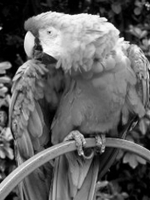

In [2]:
from IPython.display import Image as IPImage

# تأكد أن مسار الصورة صحيح
image_path = "/content/Grayscale_8bits_palette_sample_image.png"

# عرض الصورة
IPImage(filename=image_path)